# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ordblfot
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ordblfot
  Resolved https://github.com/albumentations-team/albumentations to commit 33c8927b3378145984b816b6a8bfb2171299e7ea
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


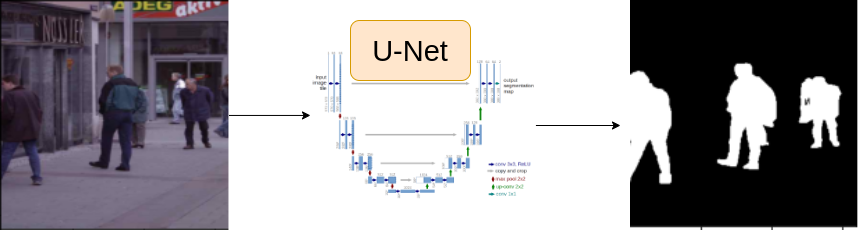

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE) / 255.0

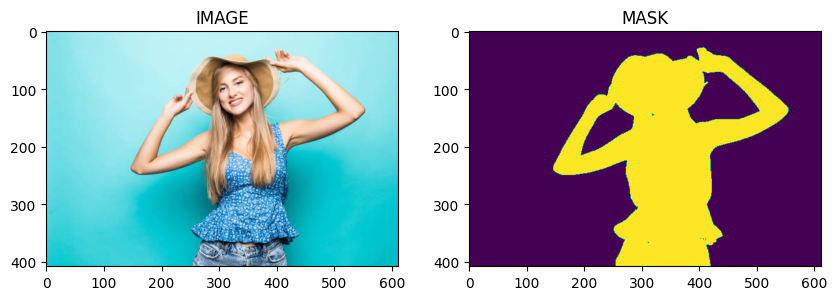

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [9]:
train_df , valid_df = train_test_split(df, test_size = 0.2 , random_state = 42 )

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)],is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),],is_check_shapes=False)


# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):

  def __init__(self, df , augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self , idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE) #(h,w,c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image , mask = mask)
      image = data['image']
      mask = data['mask']

    #(h,w,c) -> (c,h,w)

    image = np.transpose(image, (2 , 0 , 1)).astype(np.float32)
    mask = np.transpose(mask , (2 , 0 , 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image , mask


In [14]:
trainset = SegmentationDataset(train_df , get_train_augs())
validset = SegmentationDataset(valid_df , get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


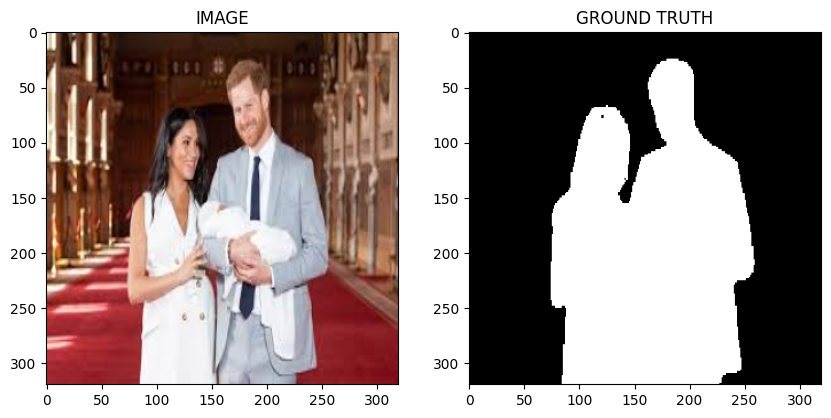

In [16]:
idx = 20

image, mask = trainset[idx]
helper.show_image(image , mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE , shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [19]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")


total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [20]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch image shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch image shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel , self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self , images , masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits , loss1 + loss2

    return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [24]:
def train_fn(data_loader , model , optimizer):

  model.train()
  total_loss = 0.0

  for images , masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images , masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [25]:
def eval_fn(data_loader , model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images , masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images , masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters() , lr = LR)

In [27]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model , optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict() , 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss = valid_loss

  print(f'Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}')

100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


SAVED MODEL
Epoch : 1 Train_loss : 0.7739603042602539 Valid_loss : 5.857048153877258


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


SAVED MODEL
Epoch : 2 Train_loss : 0.40199101070563 Valid_loss : 0.2969387248158455


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Epoch : 3 Train_loss : 0.3281353493531545 Valid_loss : 0.3013053983449936


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch : 4 Train_loss : 0.2572276920080185 Valid_loss : 0.411794226616621


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


SAVED MODEL
Epoch : 5 Train_loss : 0.24801446596781412 Valid_loss : 0.2755505442619324


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


SAVED MODEL
Epoch : 6 Train_loss : 0.21425645649433137 Valid_loss : 0.24751349166035652


100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


SAVED MODEL
Epoch : 7 Train_loss : 0.18387536803881327 Valid_loss : 0.21066982671618462


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Epoch : 8 Train_loss : 0.1636934146285057 Valid_loss : 0.22204523161053658


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


SAVED MODEL
Epoch : 9 Train_loss : 0.19518999059995015 Valid_loss : 0.18319686502218246


100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


Epoch : 10 Train_loss : 0.1841528132557869 Valid_loss : 0.20344733819365501


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


Epoch : 11 Train_loss : 0.14282272656758627 Valid_loss : 0.18572043627500534


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


SAVED MODEL
Epoch : 12 Train_loss : 0.13273896177609762 Valid_loss : 0.17976795509457588


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


Epoch : 13 Train_loss : 0.129554083943367 Valid_loss : 0.1910741999745369


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


SAVED MODEL
Epoch : 14 Train_loss : 0.11560347080230712 Valid_loss : 0.1770920790731907


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch : 15 Train_loss : 0.09320774624745051 Valid_loss : 0.2013046257197857


100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


Epoch : 16 Train_loss : 0.12600438048442206 Valid_loss : 0.20312050357460976


100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


Epoch : 17 Train_loss : 0.1793116534749667 Valid_loss : 0.27196260914206505


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Epoch : 18 Train_loss : 0.12044017960627874 Valid_loss : 0.19222623109817505


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Epoch : 19 Train_loss : 0.11537234485149384 Valid_loss : 0.2048996314406395


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Epoch : 20 Train_loss : 0.11233541270097097 Valid_loss : 0.25037259981036186


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Epoch : 21 Train_loss : 0.11579921195904413 Valid_loss : 0.22661545872688293


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch : 22 Train_loss : 0.11659305989742279 Valid_loss : 0.22342470660805702


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Epoch : 23 Train_loss : 0.1272889812787374 Valid_loss : 0.34188056364655495


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


Epoch : 24 Train_loss : 0.14325801879167557 Valid_loss : 0.23501620441675186


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]

Epoch : 25 Train_loss : 0.17127580046653748 Valid_loss : 0.33954398334026337


# Task 9 : Inference

In [32]:
idx = 17

model.load_state_dict(torch.load('/content/best_model.pt'))

image , mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  #(C , H , W) -> (1 ,C , H , W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

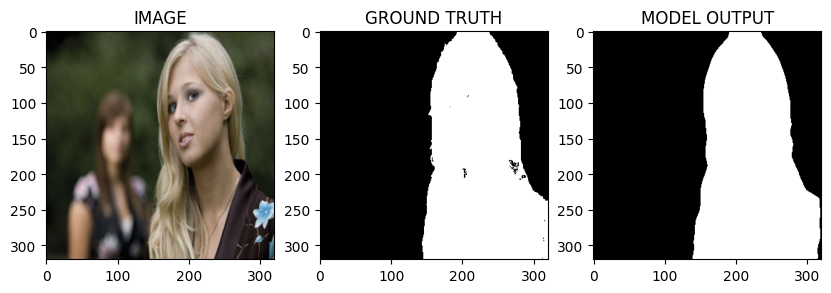

In [33]:
helper.show_image(image , mask , pred_mask.detach().cpu().squeeze(0))